In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from torch.nn.utils.rnn import pad_sequence
from nltk import word_tokenize
import pandas as pd
import numpy as np
import re
from google.colab import drive
from torch.nn import functional as F

In [ ]:
# Mount Google Drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Read CSV files
train = pd.read_csv("/content/drive/MyDrive/Pattern/Hanjala/train.csv")
test = pd.read_csv("/content/drive/MyDrive/Pattern/Hanjala/test.csv")


In [ ]:
# Install necessary packages
!pip install torch
!pip install nltk

In [ ]:
!pip install scikit-learn matplotlib

In [ ]:
# Download NLTK data
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
!pip install transformers

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

In [ ]:
# Load the pre-trained BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-cased', num_labels=5)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, output_size):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(0.2)
        self.bilstm = nn.LSTM(embedding_dim, hidden_size, bidirectional=True, dropout=0.2, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        embedded = self.embedding(x)
        dropped = self.dropout(embedded)
        bilstm_out, _ = self.bilstm(dropped)
        avg_pool = torch.mean(bilstm_out, 1)
        output = self.fc(avg_pool)
        return output


In [ ]:
# Tokenize and pad the input sequences for BiLSTM
def preprocess_data_bilstm(data, tokenizer):
    sequences = [word_tokenize(text) for text in data['text'].values]
    sequences = [tokenizer.convert_tokens_to_ids(seq) for seq in sequences]
    padded_sequences = pad_sequence([torch.LongTensor(seq) for seq in sequences], batch_first=True)
    return padded_sequences

In [ ]:
# Convert labels to one-hot encoding
y_train = train['label'].astype(int).values
y_test = test['label'].astype(int).values

In [ ]:
MAX_SEQUENCE_LENGTH = 200

In [ ]:
# Tokenize and pad the input sequences using BERT tokenizer
train_data_bilstm = preprocess_data_bilstm(train, tokenizer)
test_data_bilstm = preprocess_data_bilstm(test, tokenizer)

In [ ]:
# Convert NumPy arrays to PyTorch tensors
X_train_tensor_bilstm = torch.tensor(train_data_bilstm)
y_train_tensor_bilstm = torch.tensor(y_train, dtype=torch.long)
X_test_tensor_bilstm = torch.tensor(test_data_bilstm)
y_test_tensor_bilstm = torch.tensor(y_test, dtype=torch.long)

<ipython-input-15-d7e3e1564e72>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor_bilstm = torch.tensor(train_data_bilstm)
<ipython-input-15-d7e3e1564e72>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test_tensor_bilstm = torch.tensor(test_data_bilstm)


In [ ]:
# Set random seed for reproducibility
torch.manual_seed(42)

In [ ]:
# Create the PyTorch model
vocab_size = len(tokenizer.get_vocab())
embedding_dim = 200
hidden_size = 200
output_size = 5
# Create the PyTorch BiLSTM model
bilstm_model = BiLSTMModel(vocab_size, embedding_dim, hidden_size, output_size)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [ ]:
# Define the loss and optimizer
criterion_bilstm = nn.CrossEntropyLoss()
optimizer_bilstm = optim.AdamW(bilstm_model.parameters(), lr=2e-5)

In [ ]:
unique_labels = train['label'].unique()
print("Unique labels:", unique_labels)

Unique labels: [5 1 3 2 4]


In [ ]:
ulabels = test['label'].unique()
print("Unique labels:", ulabels)

Unique labels: [3 1 5 4 2]


In [ ]:
label_distribution = train['label'].value_counts()
print("Label distribution:\n", label_distribution)

Label distribution:
 5    785
1    602
4    345
3    286
2    281
Name: label, dtype: int64


In [ ]:
train.head()

,text,label
0,যেমনটা আশা করছিলাম তেমনটাই দিয়েছেন,5
1,এক দোম ফালতু কেও নিবেন না,1
2,আলহামদুলিল্লাহ ভালো প্রডাক্ট এবং ভালো ভাবে পেয়...,5
3,আমার কাছে অসম্ভব সুন্দর লাগছে ছবির তুলনায় বাস্...,3
4,খুবই চমৎকার একটা ঘড়ি। ধন্যবাদ,5


In [ ]:
test.head()

,text,label
0,অনেক লুস ছিল,3
1,"ভাল না, ১৫৬ গ্রাম লোড নিতে পারেনা,",1
2,বাজে পণ্য,1
3,একদম ফালতু প্রোডাক্ট দিয়েছে।,1
4,এটা এত ছোট্ট এবং প্লাস্টিকের হালকা মোবাইল রাখল...,1


In [ ]:
print(X_train_tensor_bilstm[:5])  # Print the first 5 rows

tensor([[  100,   100,   100,   100,   100,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0],
        [28777,   100,   100,   100,   100, 26109,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0, 

In [ ]:
# Training loop for BiLSTM
y_train_tensor_bilstm -= 1
y_test_tensor_bilstm -= 1

num_epochs = 2
batch_size = 16

for epoch in range(num_epochs):
    for i in range(0, len(X_train_tensor_bilstm), batch_size):
        inputs = X_train_tensor_bilstm[i:i+batch_size]
        labels = y_train_tensor_bilstm[i:i+batch_size]

        optimizer_bilstm.zero_grad()
        outputs = bilstm_model(inputs)
        loss = criterion_bilstm(outputs, labels)
        loss.backward()
        optimizer_bilstm.step()

In [ ]:
# Evaluation for BiLSTM
bilstm_model.eval()
with torch.no_grad():
    outputs_bilstm = bilstm_model(X_test_tensor_bilstm)
    loss_bilstm = criterion_bilstm(outputs_bilstm, y_test_tensor_bilstm)

    predictions_bilstm = torch.argmax(outputs_bilstm, dim=1)
    accuracy_bilstm = (predictions_bilstm == y_test_tensor_bilstm).sum().item() / len(y_test_tensor_bilstm)

    print(f'BiLSTM Model\n  Loss: {loss_bilstm.item():.3f}\n  Accuracy: {accuracy_bilstm:.3f}')

BiLSTM Model
  Loss: 1.434
  Accuracy: 0.404


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Evaluation for BiLSTM
bilstm_model.eval()
with torch.no_grad():
    outputs_bilstm = bilstm_model(X_test_tensor_bilstm)
    predictions_bilstm = torch.argmax(outputs_bilstm, dim=1).numpy()

# Calculate Precision, Recall, and F1 Score
precision_bilstm = precision_score(y_test_tensor_bilstm.numpy(), predictions_bilstm, average='weighted')
recall_bilstm = recall_score(y_test_tensor_bilstm.numpy(), predictions_bilstm, average='weighted')
f1_bilstm = f1_score(y_test_tensor_bilstm.numpy(), predictions_bilstm, average='weighted')

print(f'BiLSTM Model\n  Precision: {precision_bilstm:.3f}\n  Recall: {recall_bilstm:.3f}\n  F1 Score: {f1_bilstm:.3f}')


BiLSTM Model
  Precision: 0.163
  Recall: 0.404
  F1 Score: 0.232


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


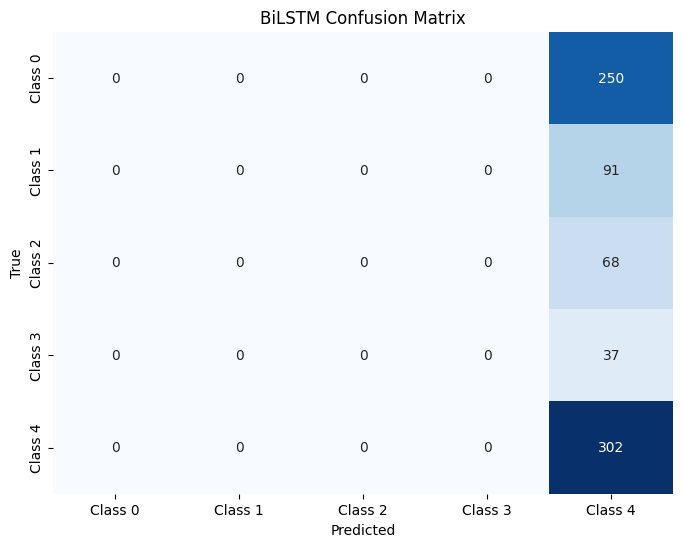

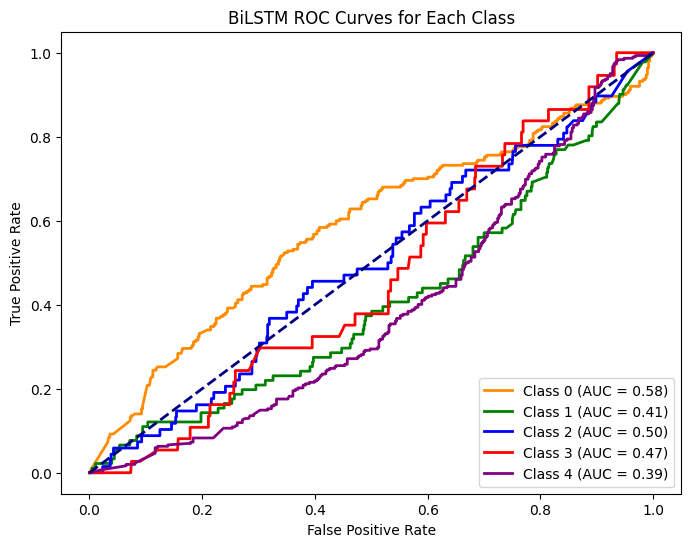

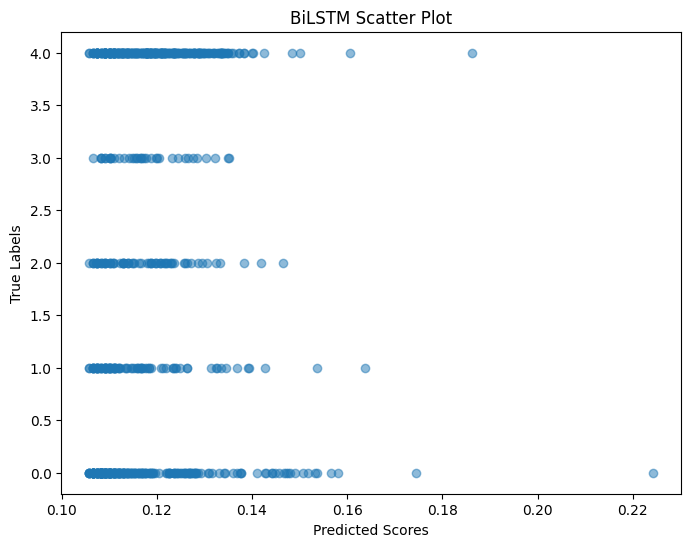

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
bilstm_model.eval()
with torch.no_grad():
    outputs_bilstm = bilstm_model(X_test_tensor_bilstm)
    predicted_labels_bilstm = torch.argmax(outputs_bilstm, dim=1).numpy()

# Create confusion matrix
cm_bilstm = confusion_matrix(y_test_tensor_bilstm.numpy(), predicted_labels_bilstm)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bilstm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('BiLSTM Confusion Matrix')
plt.show()

# ROC curve and AUC
bilstm_model.eval()
with torch.no_grad():
    outputs_bilstm = bilstm_model(X_test_tensor_bilstm)

# Compute ROC curve and AUC for each class
fpr_bilstm = dict()
tpr_bilstm = dict()
roc_auc_bilstm = dict()

for i in range(outputs_bilstm.shape[1]):
    fpr_bilstm[i], tpr_bilstm[i], _ = roc_curve((y_test_tensor_bilstm == i).numpy(), outputs_bilstm[:, i].numpy())
    roc_auc_bilstm[i] = auc(fpr_bilstm[i], tpr_bilstm[i])

# Plot ROC curves for each class
plt.figure(figsize=(8, 6))
colors = ['darkorange', 'green', 'blue', 'red', 'purple']  # Add more colors if needed

for i in range(outputs_bilstm.shape[1]):
    plt.plot(fpr_bilstm[i], tpr_bilstm[i], color=colors[i], lw=2, label=f'Class {i} (AUC = {roc_auc_bilstm[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('BiLSTM ROC Curves for Each Class')
plt.legend(loc='lower right')
plt.show()

# Scatter Plot
bilstm_model.eval()
with torch.no_grad():
    outputs_bilstm = bilstm_model(X_test_tensor_bilstm)

# Assuming you are interested in the scores for class 1 (change this if necessary)
predicted_scores_bilstm = F.softmax(outputs_bilstm, dim=1)[:, 1].numpy()

# Scatter Plot
plt.figure(figsize=(8, 6))
plt.scatter(predicted_scores_bilstm, y_test_tensor_bilstm.numpy(), alpha=0.5)
plt.xlabel('Predicted Scores')
plt.ylabel('True Labels')
plt.title('BiLSTM Scatter Plot')
plt.show()
